In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as tt
import numpy as np
from tqdm import tqdm

In [2]:
class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)
    
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [3]:
# HYPER_PARAMETER
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
device_ids = [0, 1]
NUM_CLASSES = 3
DATA_DIR = "/home/qianq/data/lits17_png"
device = get_device()
BATCH_SIZE = 16
CROP_SIZE = (512, 512) # 在代码不修改的情况 不做crop处理
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
SEG_COLORMAP = [
    [0, 0, 0], 
    [255, 255, 255], 
    [255, 106, 106], 
]
SEG_CLASSES = [
    'background', 
    'liver', 
    'tumor'
]

In [4]:
# ct_id = 120
# slice_id = 205
# mode = torchvision.io.image.ImageReadMode.RGB
# data_dir = DATA_DIR
# target_fname_liver = "seg-liver-%03d-%03d.png" % (ct_id, slice_id)
# target_fname_tumor = "seg-tumor-%03d-%03d.png" % (ct_id, slice_id)
# label_liver = torchvision.io.read_image(os.path.join(data_dir, 'target', target_fname_liver), mode)
# label_tumor = torchvision.io.read_image(os.path.join(data_dir, 'target', target_fname_tumor), mode)

In [5]:
class DownBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(DownBlock, self).__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_dim),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_dim))

    def forward(self, x):
        out = self.block(x)
        return out



class UpBlock(nn.Module):
    def __init__(self, in_dim, mid_dim, out_dim):
        super(UpBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, mid_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(mid_dim),
            nn.Conv2d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(mid_dim),
            nn.ConvTranspose2d(mid_dim, out_dim, kernel_size=2, stride=2))

    def forward(self, x):
        out = self.block(x)
        return out


class UNet(nn.Module):
    def __init__(self, num_classes, in_dim=3, conv_dim=64):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.in_dim = in_dim
        self.conv_dim = conv_dim
        self.build_unet()

    def build_unet(self):
        self.enc1 = nn.Sequential(
            nn.Conv2d(self.in_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim))
        self.enc2 = DownBlock(self.conv_dim, self.conv_dim*2)
        self.enc3 = DownBlock(self.conv_dim*2, self.conv_dim*4)
        self.enc4 = DownBlock(self.conv_dim*4, self.conv_dim*8)

        self.dec1 = UpBlock(self.conv_dim*8, self.conv_dim*16, self.conv_dim*8)
        self.dec2 = UpBlock(self.conv_dim*16, self.conv_dim*8, self.conv_dim*4)
        self.dec3 = UpBlock(self.conv_dim*8, self.conv_dim*4, self.conv_dim*2)
        self.dec4 = UpBlock(self.conv_dim*4, self.conv_dim*2, self.conv_dim)

        self.last = nn.Sequential(
            nn.Conv2d(self.conv_dim*2, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.conv_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.conv_dim),
            nn.Conv2d(self.conv_dim, self.num_classes, kernel_size=1, stride=1))

    def forward(self, x):
        enc1 = self.enc1(x) # 16
        enc2 = self.enc2(enc1) # 8
        enc3 = self.enc3(enc2) # 4
        enc4 = self.enc4(enc3) # 2

        center = nn.MaxPool2d(kernel_size=2, stride=2)(enc4)

        dec1 = self.dec1(center) # 4
        dec2 = self.dec2(torch.cat([enc4, dec1], dim=1))
        dec3 = self.dec3(torch.cat([enc3, dec2], dim=1))
        dec4 = self.dec4(torch.cat([enc2, dec3], dim=1))

        last = self.last(torch.cat([enc1, dec4], dim=1))
        assert x.size(-1) == last.size(-1), 'input size(W)-{} mismatches with output size(W)-{}' \
                                            .format(x.size(-1), last.size(-1))
        assert x.size(-2) == last.size(-2), 'input size(H)-{} mismatches with output size(H)-{}' \
                                            .format(x.size(-1), last.size(-1))
        return last

In [6]:
class LiverSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the LitsLiverDataset`"""

    normalize_transform = tt.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __init__(self, is_train, crop_size, data_dir, object='liver'):
        """
        object[choice]:
            liver: liver-only
            tumor: tumor-only
            all: liver + tumor
        """
        self.transform = self.normalize_transform
        self.crop_size = crop_size
        self.is_train = is_train
        self.data_dir = data_dir
        self.object = object

        self.source_images = os.listdir(os.path.join(data_dir, 'source'))
        self.train_source_list = []
        self.test_source_list = []
        for fname in self.source_images:
            ct_id, slice_id = self.fname_to_ids(fname)
            ct_id = int(ct_id)
            if ct_id <= 115:
                self.train_source_list.append(fname)
            elif ct_id > 115:
                self.test_source_list.append(fname)
        self.colormap2label = self.get_colormap2label()

    @classmethod
    def normalize_image(cls, img):
        return cls.normalize_transform(img.float() / 255)

    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = self.read_single_image(
            object=self.object, 
            idx=idx,
        )
        feature = self.normalize_image(feature)
        feature, label = self.rand_crop(feature, label,*self.crop_size)
        return (feature, self.label_indices(label, self.colormap2label))

    def __len__(self):
        if self.is_train:
            return len(self.train_source_list)
        else:
            return len(self.test_source_list)

    def read_single_image(self, idx, object='liver'):
        mode = torchvision.io.image.ImageReadMode.RGB
        if self.is_train:
            source_images_list = self.train_source_list
        else:
            source_images_list = self.test_source_list
        fname = source_images_list[idx]
        ct_id, slice_id = self.fname_to_ids(fname)
        ct_id = int(ct_id)
        slice_id = int(slice_id)
        feature = torchvision.io.read_image(
            os.path.join(self.data_dir, 'source', fname),
            mode,
        )
        target_fname_liver = "seg-liver-%03d-%03d.png" % (ct_id, slice_id)
        target_fname_tumor = "seg-tumor-%03d-%03d.png" % (ct_id, slice_id)

        if object in ['liver','tumor']:
            target_fname = target_fname_liver if object == 'liver' else target_fname_tumor
            label = torchvision.io.read_image(os.path.join(self.data_dir, 'target', target_fname), mode)
        else:
            # live + tumor
            label_liver = torchvision.io.read_image(os.path.join(self.data_dir, 'target', target_fname_liver), mode)
            label_tumor = torchvision.io.read_image(os.path.join(self.data_dir, 'target', target_fname_tumor), mode)
            label_idx = label_tumor[0] == 255
            label_tumor[1][label_idx] = 106
            label_tumor[2][label_idx] = 106
            label = label_liver + label_tumor
        return feature, label

    # @classmethod
    # def read_images(cls, data_dir, object='liver', is_train=True):
    #     """
    #     Read all Lits feature and liver-label images on the memory
    #     [warning] it may cause machine crash
    #     object[choice]:
    #         - liver
    #         - tumor
    #     is_train:
    #         - True: first 100 ct samples
    #         - False: last 30 ct samples
    #     """
    #     mode = torchvision.io.image.ImageReadMode.RGB
    #     features, labels = [], []
    #     images = os.listdir(os.path.join(data_dir, 'source'))
    #     pbar = tqdm(total=len(images))
    #     for i, fname in enumerate(images):
    #         ct_id, slice_id = cls.fname_to_ids(fname)
    #         ct_id = int(ct_id)
    #         slice_id = int(slice_id)
    #         if is_train and ct_id > 100:
    #             continue
    #         elif (not is_train) and ct_id <= 100:
    #             continue
    #         features.append(torchvision.io.read_image(
    #             os.path.join(data_dir, 'source', fname), mode)
    #         )
    #         if object == 'liver':
    #             target_fname = "seg-liver-%03d-%03d.png" % (ct_id, slice_id)
    #         else:
    #             target_fname = "seg-tumor-%03d-%03d.png" % (ct_id, slice_id)
    #         label = torchvision.io.read_image(os.path.join(data_dir, 'target', target_fname), mode)
    #         labels.append(label)
    #         pbar.update(1)
    #     return features, labels

    @classmethod
    def fname_to_ids(cls, fname):
        """
        return ct_id and ct_slice_id
        volume-001-058.png -> 1, 58
        """
        seg_list = fname.split('-')
        return seg_list[1], seg_list[2].replace('.png', '')

    def get_colormap2label(self):
        """Build the mapping from RGB to class indices for labels.

        Defined in :numref:`sec_semantic_segmentation`"""
        colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
        for i, colormap in enumerate(SEG_COLORMAP):
            colormap2label[
                (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
        return colormap2label

    def rand_crop(self, feature, label, height, width):
        """Randomly crop both feature and label images.

        Defined in :numref:`sec_semantic_segmentation`"""
        rect = torchvision.transforms.RandomCrop.get_params(
            feature, (height, width))
        feature = torchvision.transforms.functional.crop(feature, *rect)
        label = torchvision.transforms.functional.crop(label, *rect)
        return feature, label

    def label_indices(self, colormap, colormap2label):
        """Map any RGB values in labels to their class indices.

        Defined in :numref:`sec_semantic_segmentation`"""
        colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
        idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
               + colormap[:, :, 2])
        return colormap2label[idx]

    @classmethod
    def label2image(cls, pred, device):
        colormap = torch.tensor(SEG_COLORMAP, device=device)
        X = pred.long()
        return colormap[X, :]

In [7]:
class AverageMeter:
    ''' Computes and stores the average and current value '''
    def __init__(self) -> None:
        self.reset()

    def reset(self) -> None:
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val: float, n: int = 1) -> None:
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

def load_data_lits(batch_size, crop_size):
    """Load the LITS liver semantic segmentation dataset.

    Defined in :numref:`sec_semantic_segmentation`"""
    data_dir = DATA_DIR
    num_workers = get_dataloader_workers()
    
    train_iter = torch.utils.data.DataLoader(
        LiverSegDataset(True, crop_size, data_dir, object='all'), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        LiverSegDataset(False, crop_size, data_dir, object='all'), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter

# def loss(inputs, targets):
#     return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)


def pixel_accuracy(y_hat, y):
    """Compute the number of correct predictions.[each pixel]

    Defined in :numref:`sec_softmax_scratch`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    size = 1
    for s in cmp.shape:
        size *= s
    return float(cmp.sum()/size)


def calc_iou(pred, target, n_classes = 2):
    #n_classes ：the number of classes in your dataset
    ious = []
    pred = argmax(pred, axis=1)
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
        # if union == 0:
        #     ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        # else:
        #     ious.append(float(intersection) / float(max(union, 1)))
        if union != 0:
            ious.append(float(intersection)/float(max(union, 1)))
        else:
            ious.append(None)
    # return np.array(ious)
    return ious


def calc_dice(pred, target, n_classes = 2):
    # n_classes ：the number of classes in your dataset
    dice = []
    pred = argmax(pred, axis=1)
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection
        # if union == 0:
        #     ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        # else:
        #     ious.append(float(intersection) / float(max(union, 1)))
        if union != 0:
            dice.append(float(intersection*2)/float(max(union, 1) + intersection))
        else:
            dice.append(None)
    # return np.array(ious)
    return dice

In [8]:
train_iter, test_iter = load_data_lits(BATCH_SIZE, CROP_SIZE)
train_dl = ToDeviceLoader(train_iter, device)
test_dl = ToDeviceLoader(test_iter, device)

In [9]:
model = UNet(num_classes=NUM_CLASSES)
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=device_ids)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.CrossEntropyLoss(
    weight=torch.from_numpy(np.array([1/810, 1/18, 1])).float(), 
    size_average=True,
) # 带权重的交叉熵 权重为样本比例的倒数
criterion.to(device)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, LEARNING_RATE, eta_min=0)
lr_scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, LEARNING_RATE, total_iters=NUM_EPOCHS)
# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(train_dl)+1)

/home/qianq/mycodes/lits17-seg/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [10]:
def train(train_iter, model, criterion, optimizer, epoch, total_epochs, lr_scheduler):
    loss_metric = AverageMeter()
    pixel_acc_metric = AverageMeter()
    liver_miou_metric = AverageMeter()
    tumor_miou_metric = AverageMeter()
    num_steps = len(train_iter)
    lr_rate = lr_scheduler.get_last_lr()
    pbar = tqdm(total=num_steps)
    pbar.set_description(f"[Train] EPOCH [{epoch}/{total_epochs}], lr=[{lr_rate}]:")
    for i, (x, y) in enumerate(train_iter):
        batch_cnt = x.shape[0]
        model.train()
        optimizer.zero_grad()
        pred = model(x)
        l = criterion(pred, y)
        train_loss_sum = l.sum()
        train_loss_sum.backward()
        acc_sum = pixel_accuracy(pred, y)
        dices = calc_dice(pred, y, NUM_CLASSES)
        optimizer.step()
        lr_scheduler.step()
        loss_metric.update(float(train_loss_sum), n=batch_cnt)
        if dices[0]:
            liver_miou_metric.update(dices[0], n=1)
        if dices[1]:
            tumor_miou_metric.update(dices[1], n=1)
        pixel_acc_metric.update(acc_sum, n=1)
        pbar.update(1)
        pbar.set_postfix(
            loss=loss_metric.avg, 
            pixel_acc=pixel_acc_metric.avg, 
            liver_dice=liver_miou_metric.avg,
            tumor_dice=tumor_miou_metric.avg,
        )
    return loss_metric.avg, pixel_acc_metric.avg, liver_miou_metric.avg, tumor_miou_metric.avg


def valid(test_iter, model, criterion, epoch, total_epochs, lr_scheduler):
    loss_metric = AverageMeter()
    pixel_acc_metric = AverageMeter()
    liver_miou_metric = AverageMeter()
    tumor_miou_metric = AverageMeter()
    num_steps = len(test_iter)
    lr_rate = lr_scheduler.get_last_lr()
    pbar = tqdm(total=num_steps)
    pbar.set_description(f"[Valid] EPOCH [{epoch}/{total_epochs}], lr=[{lr_rate}]:")
    for i, (x, y) in enumerate(test_iter):
        batch_cnt = x.shape[0]
        model.train()
        optimizer.zero_grad()
        pred = model(x)
        l = criterion(pred, y)
        train_loss_sum = l.sum()
        acc_sum = pixel_accuracy(pred, y)
        dices = calc_iou(pred, y, NUM_CLASSES)
        optimizer.step()
        lr_scheduler.step()
        loss_metric.update(float(train_loss_sum), n=batch_cnt)
        if dices[0]:
            liver_miou_metric.update(dices[0], n=1)
        if dices[1]:
            tumor_miou_metric.update(dices[1], n=1)
        pixel_acc_metric.update(acc_sum, n=1)
        pbar.update(1)
        pbar.set_postfix(
            loss=loss_metric.avg, 
            pixel_acc=pixel_acc_metric.avg, 
            liver_dice=liver_miou_metric.avg,
            tumor_dice=tumor_miou_metric.avg,
        )
    return loss_metric.avg, pixel_acc_metric.avg, liver_miou_metric.avg, tumor_miou_metric.avg

In [11]:
history = []
for epoch in range(1, NUM_EPOCHS+1):
    print('-' * 50)
    lr_scheduler.get_last_lr
    train_loss, train_pixel_acc, train_liver_dice, train_tumor_dice = train(train_dl, model, criterion, optimizer, epoch, NUM_EPOCHS, lr_scheduler)
    valid_loss, valid_pixel_acc, valid_liver_dice, valid_tumor_dice = valid(test_dl, model, criterion, epoch, NUM_EPOCHS, lr_scheduler)
    history.append({
        "epoch": epoch, 
        "train_loss": train_loss, 
        "train_pixel_acc": train_pixel_acc, 
        "train_liver_dice": train_liver_dice, 
        "train_tumor_dicd": train_tumor_dice, 
        "test_loss": valid_loss, 
        "test_pixel_acc": valid_pixel_acc, 
        "test_liver_dice": valid_liver_dice, 
        "test_tumor_dice": valid_tumor_dice, 
    })

--------------------------------------------------


[Train] EPOCH [1/10], lr=[[1e-06]]::  25%|██▌       | 791/3148 [04:59<14:36,  2.69it/s, liver_dice=0.413, loss=0.487, pixel_acc=0.88, tumor_dice=0.0359]  

In [ ]:
def show_imgs(imgs):
    row_cnt = len(imgs)
    col_cnt = len(imgs[0])
    plt.figure(figsize=(6,8)) #设置窗口大小
    plt.suptitle('liver seg') # 图片名称
    i = 0
    for (source, pred, target) in imgs:
        s_idx = i*col_cnt + 1
        p_idx = s_idx + 1
        t_idx = p_idx + 1
        plt.subplot(row_cnt, col_cnt, s_idx), plt.title('source')
        plt.imshow(source), plt.axis('off')
        plt.subplot(row_cnt, col_cnt, p_idx), plt.title('pred')
        plt.imshow(pred), plt.axis('off') #这里显示灰度图要加cmap
        plt.subplot(row_cnt, col_cnt, t_idx), plt.title('target')
        plt.imshow(target), plt.axis('off')
        i = i+1
    plt.show()

def plot(x:list, y:list, x_label:str, y_label:str):
    """
    show training metrics
    """
    plt.style.use('_mpl-gallery')

    # plot
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0)

    # ax.set(xlim=(0, 10000), xticks=np.arange(1, 8),
    #        ylim=(0, 8), yticks=np.arange(1, 8))

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


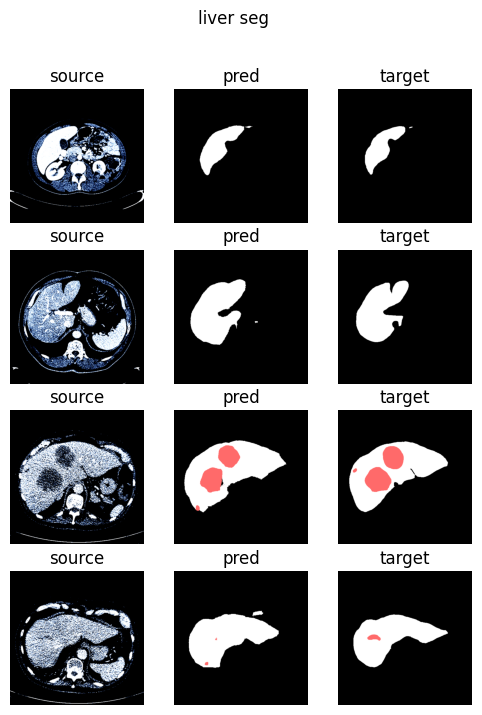

In [ ]:
ds = LiverSegDataset(False, CROP_SIZE, DATA_DIR, object='all')
idx1 = ds.test_source_list.index("volume-120-191.png")
idx2 = ds.test_source_list.index("volume-129-228.png")
idx_list = [idx1, idx1+500, idx2, idx2+50]
n = 4
X = torch.zeros((n, 3, 512, 512))
Y = torch.zeros((n, 512, 512))

for i in range(n):
    X[i], Y[i] = ds[idx_list[i]]

y_hat = model(X).argmax(dim=1)
# print(X.shape)
imgs = []

for i in range(n):
    x = X[i].permute(1, 2, 0).to('cpu')
    pred = LiverSegDataset.label2image(y_hat[i], device).to('cpu')
    y = LiverSegDataset.label2image(Y[i], device).to('cpu')
    imgs.append([x, pred, y])

show_imgs(imgs)
# print(imgs[0].shape)

In [ ]:
torch.save(model.state_dict(), 'fcn.ckpt')